In [206]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import pickle
import sklearn.metrics as metrics
import imblearn
from imblearn.over_sampling import SMOTE
from collections import Counter
import matplotlib.pyplot as plt
from numpy import where
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

In [207]:
#XGBoost Wighted
infile_weight = open('XGBoost_model.sav','rb')
model_weight = pickle.load(infile_weight)
infile_weight.close()
#XGBoost SMOOTE
infile_smoote = open('XGBoost_model_smote.sav','rb')
model_smoote = pickle.load(infile_smoote)
infile_smoote.close()

In [208]:
flights = pd.read_csv('data/flights.csv')
flights = flights[['fl_date','mkt_carrier','origin','dest'
                  ,'taxi_out','taxi_in','cancelled','crs_elapsed_time','arr_delay']]

#features and target
X = flights.loc[:,flights.columns!='cancelled']
y = flights[['cancelled']]

In [209]:
X['fl_date'] = pd.to_datetime(X['fl_date'],format='%Y-%m-%d')
X['year'] = pd.DatetimeIndex(X['fl_date']).year
X['month'] = pd.DatetimeIndex(X['fl_date']).month
X['day'] = pd.DatetimeIndex(X['fl_date']).day
X = X[['month','day','origin','dest','crs_elapsed_time']]
X= pd.get_dummies(X,columns=['origin','dest'])

### XGBoost Without SMOTE

In [210]:
#calculating the weights of class 0 to 1
class_0 = y.loc[y['cancelled'] == 0].value_counts().values[0]
class_1 = y.loc[y['cancelled'] == 1].value_counts().values[0]
weight = class_0/class_1
print('Ratio of Class 0 to Class 1:',weight)

Ratio of Class 0 to Class 1: 60.72839506172839


In [211]:
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True,test_size=0.30, random_state=123)

In [212]:
y_pred = model_weight.predict(X_test.values)
print('roc_auc score for weighted model:',roc_auc_score(y_test,y_pred))
print('accuracy score: ',accuracy_score(y_test,y_pred))
print('f1 score: ',f1_score(y_test,y_pred))
c = confusion_matrix(y_test,y_pred)

roc_auc score for weighted model: 0.6553020324612396
accuracy score:  0.7326555555555555
f1 score:  0.06468415937803693


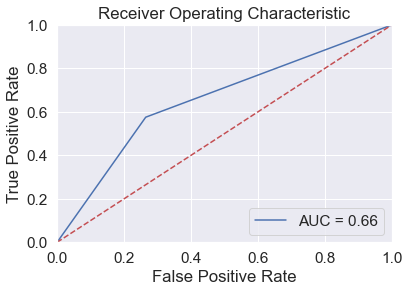

In [213]:
#plotting the ROC_AUC
probs = model_weight.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

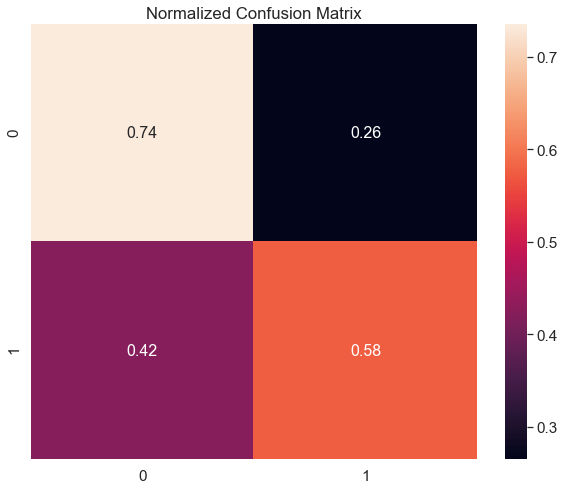

In [214]:
#Normalized Confusion Matrix
normed_c = (c.T / c.astype(np.float).sum(axis=1)).T
plt.figure(figsize=(10,8))
df_cm = normed_c
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.title('Normalized Confusion Matrix')
plt.show()

### XGBoost With SMOTE

In [215]:
oversample = SMOTE(random_state=0)
X_resampled, y_resampled = oversample.fit_sample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled,shuffle=True,\
                                                    stratify=y_resampled, test_size=0.30, random_state=123)
y_pred_weight = model_weight.predict(X_test.values)

In [216]:
#printing the scores
print('roc_auc score for SMOTE:', roc_auc_score(y_test,y_pred_weight))
print('f1 score for SMOTE:', f1_score(y_test,y_pred_weight))
print('accuracy score: ',accuracy_score(y_test,y_pred_weight))

roc_auc score for SMOTE: 0.7103465022249328
f1 score for SMOTE: 0.7021952309898569
accuracy score:  0.7103465022249328


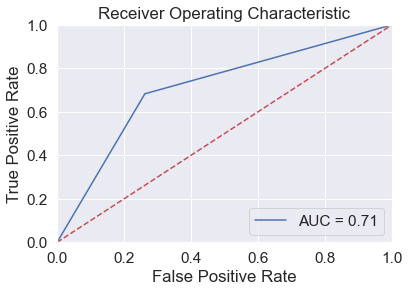

In [217]:
probs = model_smoote.predict_proba(X_test)
preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred_weight)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

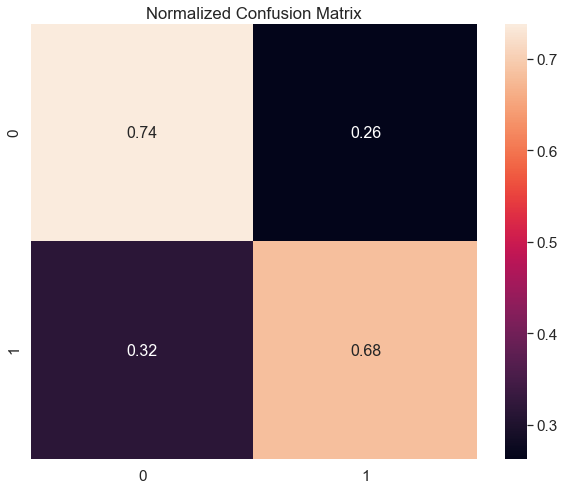

In [218]:
c = confusion_matrix(y_test,y_pred_weight)
normed_c = (c.T / c.astype(np.float).sum(axis=1)).T
plt.figure(figsize=(10,8))
df_cm = normed_c
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.title('Normalized Confusion Matrix')
plt.show()